In [5]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Period based data

In [2]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
ncx = ncx1 + ncx2 + ncx3 + ncx4


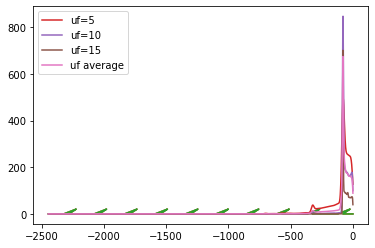

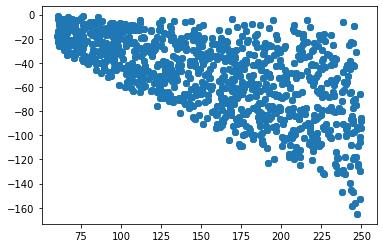

In [3]:
# Combine data
plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_p*n_periods, 0, ncx*n_periods+1)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.scatter(inputPara_raw[2,:], inputPara_raw[4,:])

In [4]:
ntrain = 800
ntest = 200

batch_size = 20
learning_rate = 0.001
epochs = 501
step_size = 100
gamma = 0.5


modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_period_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
82373057
0 12.240508750081062 0.6081905627250671 0.6969865560531616
1 8.434287835843861 0.5447051358222962 0.4585844612121582
2 8.442229893989861 0.43662900030612944 0.38338881969451905
3 8.439113429747522 0.3944315272569656 0.3843264698982239
4 8.426834476180375 0.3676333445310593 0.3608608889579773
5 8.438001326285303 0.35237868785858156 0.3622427988052368
6 8.438571649603546 0.3312471520900726 0.33309652090072633
7 8.437509216368198 0.31896291255950926 0.274640588760376
8 8.441334309056401 0.30091687858104704 0.29220349550247193
9 8.436631647869945 0.2795311361551285 0.25616548538208006
10 8.433093908242881 0.28038372099399567 0.2750536513328552
11 8.435333256609738 0.2517251145839691 0.22901174783706665
12 8.442471381276846 0.21912420332431792 0.21042216300964356
13 8.426256651058793 0.29714870572090146 0.23248251676559448
1

# Length based data

In [6]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

L_x = 1000
N_s, L_x = 2001, 1000


Text(0, 0.5, 'x3')

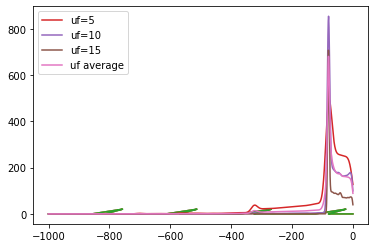

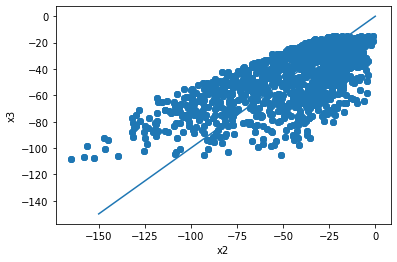

In [7]:
# Combine data
plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_x, 0, N_s)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.plot(np.linspace(-150,0,100), np.linspace(-150,0,100))
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel("x2")
plt.ylabel("x3")

In [13]:
ntrain = 900
ntest = 100

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5

n_periods = 10
# modes = n_periods*16
# width = n_periods*32

modes = 64
width = 64
# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)
test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
                                          shuffle=False)

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
1336001
0 1.2050242898985744 0.6662478605906169 0.610375919342041
1 1.196335081011057 0.5975744448767768 0.6157361125946045
2 1.1948500229045749 0.5887155702379014 0.6391059970855713
3 1.1951986122876406 0.5876205677456326 0.6184028148651123
4 1.1947586806491017 0.5833686394161648 0.6134527492523193
5 1.1949851587414742 0.5848476886749268 0.6140316104888917
6 1.1979009229689837 0.5930691666073269 0.618716630935669
7 1.199274837039411 0.587342669169108 0.6080921268463135
8 1.1967342058196664 0.5811885113186307 0.6071086692810058
9 1.1958409883081913 0.5814905410342747 0.6275426197052002
10 1.1913645910099149 0.5776568094889323 0.5989490604400635
11 1.1887069372460246 0.5437089517381456 0.5294379234313965
12 1.1917917476966977 0.4684998236762153 0.46644476890563963
13 1.1933229910209775 0.43613527456919354 0.4272239923477173
14 1.

In [12]:
# zero tests 

ntrain = 1000

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5

n_periods = 10
# modes = n_periods*16
# width = n_periods*32
modes = 64
width = 64
# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain)
train_index = index[:ntrain]

x_train = input[train_index]
y_train = output[train_index]
x_train = x_train.reshape(ntrain, s, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)                                 

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        
        train_l2 /= ntrain

        t2 = default_timer()
        print(ep, t2 - t1, train_l2)

        # plot
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))



inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
172513
0 1.079538431018591 0.6592364664077759
1 0.8473007259890437 0.5914841451644898
2 0.8433148255571723 0.5873975992202759
3 0.8483765721321106 0.5871702203750611
4 0.8528432650491595 0.5917837972640991
5 0.8554329816251993 0.5829078912734985
6 0.8474134057760239 0.5471537027359009
7 0.855564272031188 0.4978681745529175
8 0.853367218747735 0.47141829681396485
9 0.853265498764813 0.4351291813850403
10 0.8524163831025362 0.4139124021530151
11 0.8565951474010944 0.38561981439590454
12 0.8498787460848689 0.36212570810317996
13 0.8531505167484283 0.3503162479400635
14 0.8589995941147208 0.3288366560935974
15 0.8527163788676262 0.3230340166091919
16 0.8521300228312612 0.3178385243415833
17 0.8356064287945628 0.30095332384109497
18 0.8536941464990377 0.30103828144073486
19 0.850562633946538 0.2883832335472107
20 0.8568812031298876 0